__三维数据预处理及输入尺寸标准化模块__

In [ ]:
import scipy.io as io
import numpy as np

def datapreprocessing(matdata):

    #导入数据并处理为完全0-1分布
    # data = io.loadmat('../../Matlab_files/Matlab_files/top3d_Cantilever_new/top3d_Cantilever_new_50.mat')
    data = matdata['data']
    data = np.array(data)
    print('数据初始维度：',data.shape)
    data = data.transpose(1, 2, 0)
    print('数据调整后维度：',data.shape)#(x,z,y)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                if data[i][j][k] > 0.5:
                    data[i][j][k] = 1
                else:
                    data[i][j][k] = 0

    #数据尺寸扩展为标准尺寸
    nelx, nely, nelz = 160, 160, 160
    if (nelx - data.shape[0])%2 !=0:
        data = np.pad(data, ((1, 0), (0, 0), (0 ,0)))
    if (nelz - data.shape[1])%2 !=0:
        data = np.pad(data, ((0, 0), (1, 0), (0 ,0)))
    if (nely - data.shape[2])%2 !=0:
        data = np.pad(data, ((0, 0), (0, 0), (1 ,0)))
    data_new = np.pad(data, (((nelx - data.shape[0])//2, (nelx - data.shape[0])//2),
                        ((nely - data.shape[1])//2, (nely - data.shape[1])//2),
                        ((nelz - data.shape[2])//2, (nelx - data.shape[2])//2)))
    print('数据标准化后维度：',data_new.shape)
    return data_new

__六方体行进法遍历模型，寻找断裂点，单共享边修复模块__

In [ ]:
def datarepair(data_new):
    
    label_data = np.zeros((160, 160, 160))
    face_voxel = []
    n = 0
    for i in range(data_new.shape[0]):
        for j in range(data_new.shape[1]):
            for k in range(data_new.shape[2]):
                if data_new[i][j][k] !=0:
                    face_voxel.append(data_new[i-1][j][k])
                    print('1:',face_voxel)
                    face_voxel.append(data_new[i+1][j][k])
                    print('2:',face_voxel)
                    face_voxel.append(data_new[i][j-1][k])
                    print('3:',face_voxel)
                    face_voxel.append(data_new[i][j+1][k])
                    print('4:',face_voxel)
                    face_voxel.append(data_new[i][j][k-1])
                    print('5:',face_voxel)
                    face_voxel.append(data_new[i][j][k+1])
                    print('6:',face_voxel)
                    sum_value = sum(face_voxel)
                    print('face_voxel:',face_voxel)

                    if sum_value == 0 or sum_value == 1:
                        # label_data[i-2:i+2,j-2:j+2,k-2:k+2] = data_new[i-2:i+2,j-2:j+2,k-2:k+2]
                        # data_new[i-1, j-1, k+1] = 1
                        data_new[i, j, k-1] = 1

                    face_voxel = []
                n += 1
    print('遍历了：',n,'次')
    data_repair = data_new
    return data_repair


    #绘制抓取的缺陷结构
    # mycolormap = plt.get_cmap('winter')
    # label_data_max = label_data.max()
    # relativevalue = np.round(label_data / label_data_max, 1)
    # colorsvalues = mycolormap(relativevalue)
    # fig = plt.figure(figsize=(10, 10))
    # ax = fig.add_subplot(projection='3d')
    # ax.set_xlabel('X Axis')
    # ax.set_ylabel('Y Axis')
    # ax.set_zlabel('Z Axis')
    # ax.set_xlim(0, 150)
    # ax.set_ylim(0, 150)
    # ax.set_zlim(75, -75)
    # ax.voxels(label_data, facecolors=colorsvalues,edgecolors = 'k', shade = False)

__.npy文件转.mat文件模块__

In [ ]:
# import scipy.io as io
# io.savemat('../../topdata/topdata/topdata_mat/top3d_Cantilever_new.mat',{'data':data_new})

__三维输入结构随机断裂模块__

In [ ]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
def generate_input(data_new):
    #随机断开模型结构
    extract_data = 0
    i = 0
    while extract_data ==0:
        index = np.random.randint(0, 100, size=(3, ))
        extract_data = data_new[index[0]][index[1]][index[2]]
        i +=1
    print('进行了',i,'次搜索')
    print(extract_data)
    i, j ,k = index[0], index[1], index[2]
    print('i, j, k:',i,j,k)
    for m in range(i-3,i+4):
        for n in range(j-3, j+4):
            for t in range(k-3, k+4):
                data_new[m][n][t] = 0

    input_data = data_new
    return input_data

__循环生成数据集__

In [ ]:
import numpy as np
import glob
import os
import scipy.io as io
sample_amount = 5
matdata_index = glob.glob('../../Matlab_files/Matlab_files/matdata/*.mat')
label_save_path = '../../topdata/topdata/dataset/label/'
m = 0
for i in range(len(matdata_index)):

    for t in range(sample_amount):
        matdata = io.loadmat(matdata_index[i])
        data_new = datapreprocessing(matdata)
        data_repair = datarepair(data_new)
        np.save(os.path.join(label_save_path,'%d.npy' %t),data_repair)
        inputdata = generate_input(data_repair)
        input_save_path = label_save_path.replace('label/','input/')
        np.save(os.path.join(input_save_path, '%d.npy' %t),inputdata)
 
print('数据集制作完成')

In [2]:
import scipy.io as io
import numpy as np
import glob
import os


inputdata_addr = '../../Matlab_files/dataset/matdata/input/'
inputdata_saveaddr = '../../Matlab_files/dataset/Dataset/input/'
inputdata_index = glob.glob(os.path.join(inputdata_addr, '*.mat'))
for i in range(len(inputdata_index)):
    print('读取第：',i,'组数据')
    inputmatdata = io.loadmat(inputdata_index[i])
    inputdata = inputmatdata['standarddata']
    inputdata = inputdata[np.newaxis,:,:,:]
    np.save(os.path.join(inputdata_saveaddr, '%d.npy'%i),inputdata)
    labeldata_index = glob.glob(os.path.join(inputdata_addr.replace('input/','label/'),'*.mat'))
    labeldata_saveaddr = inputdata_saveaddr.replace('input/','label/')
    labelmatdata = io.loadmat(labeldata_index[i])
    labeldata = labelmatdata['repairdata']
    labeldata = labeldata[np.newaxis,:,:,:]
    np.save(os.path.join(labeldata_saveaddr, '%d.npy'%i),labeldata)
print('数据集生成完毕！')

    





读取第： 0 组数据
读取第： 1 组数据
读取第： 2 组数据
读取第： 3 组数据
读取第： 4 组数据
读取第： 5 组数据
读取第： 6 组数据
读取第： 7 组数据
读取第： 8 组数据
数据集生成完毕！


第 0 组输入数据
第 1 组输入数据
第 2 组输入数据
第 3 组输入数据
第 4 组输入数据
第 5 组输入数据
第 0 组标签数据
第 1 组标签数据
第 2 组标签数据
第 3 组标签数据
第 4 组标签数据
第 5 组标签数据


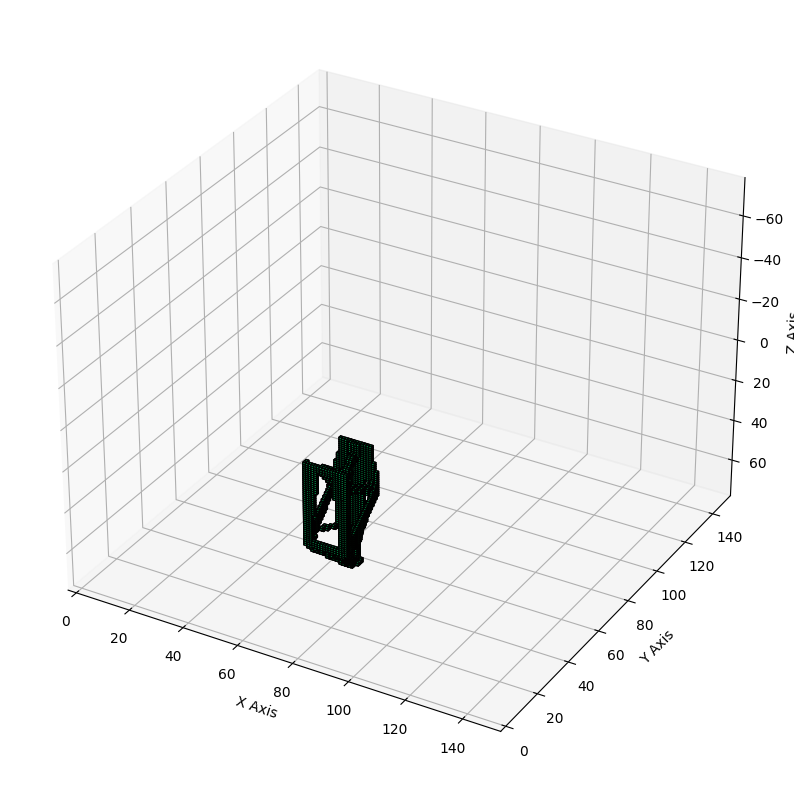

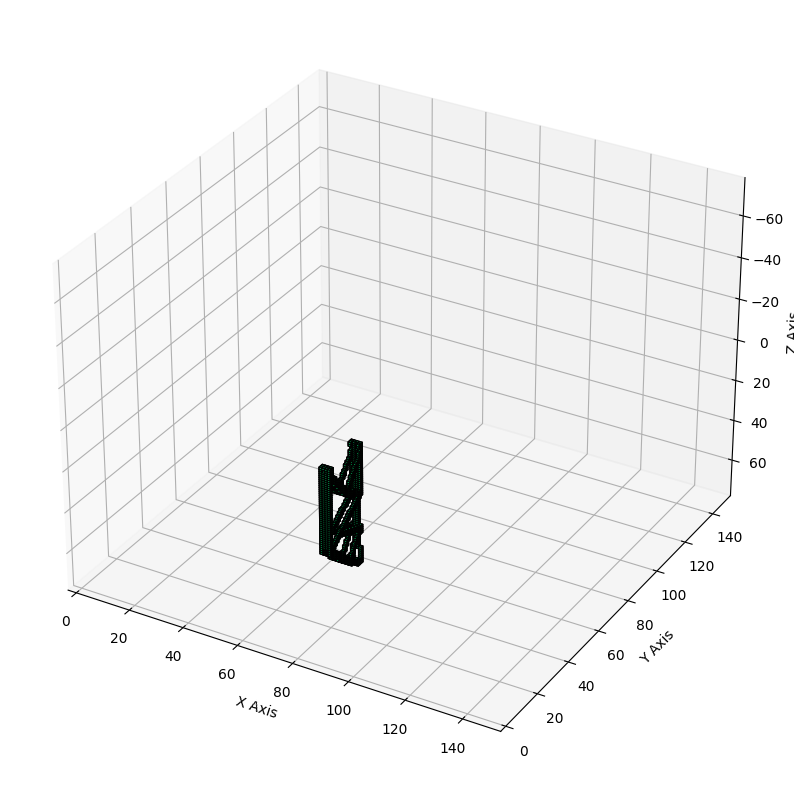

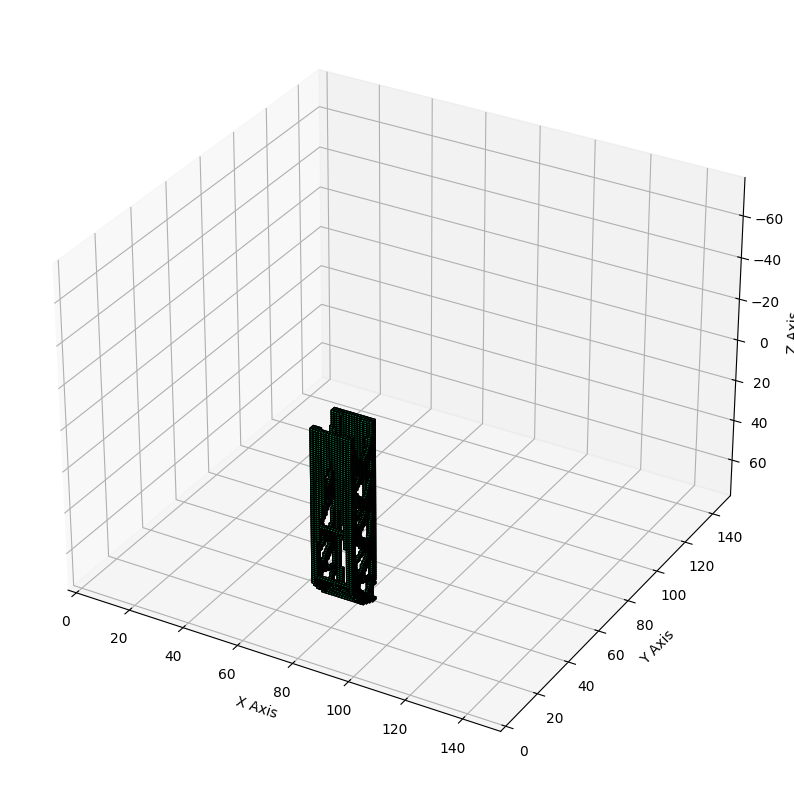

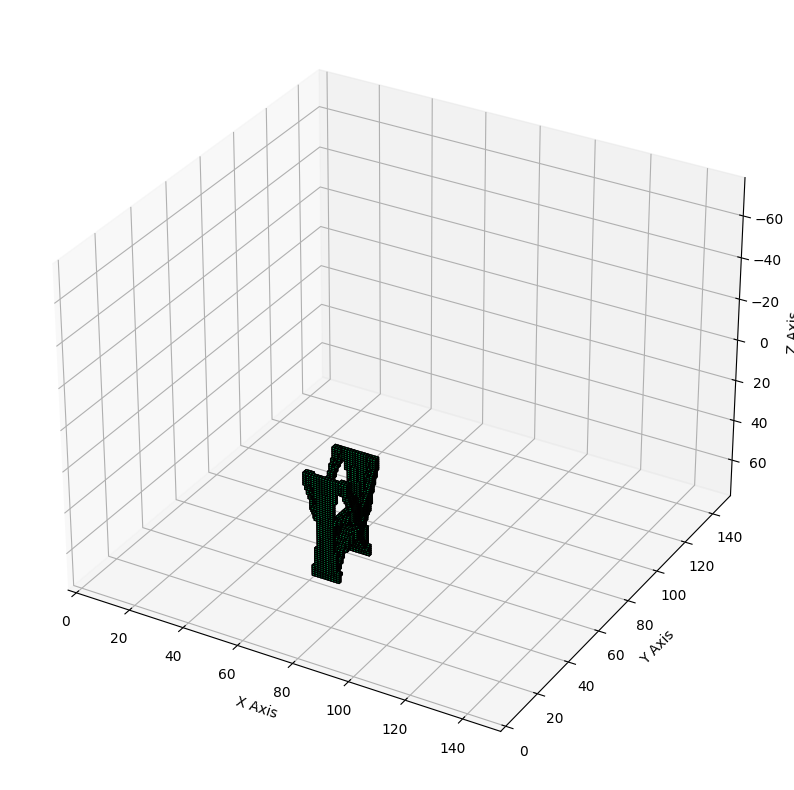

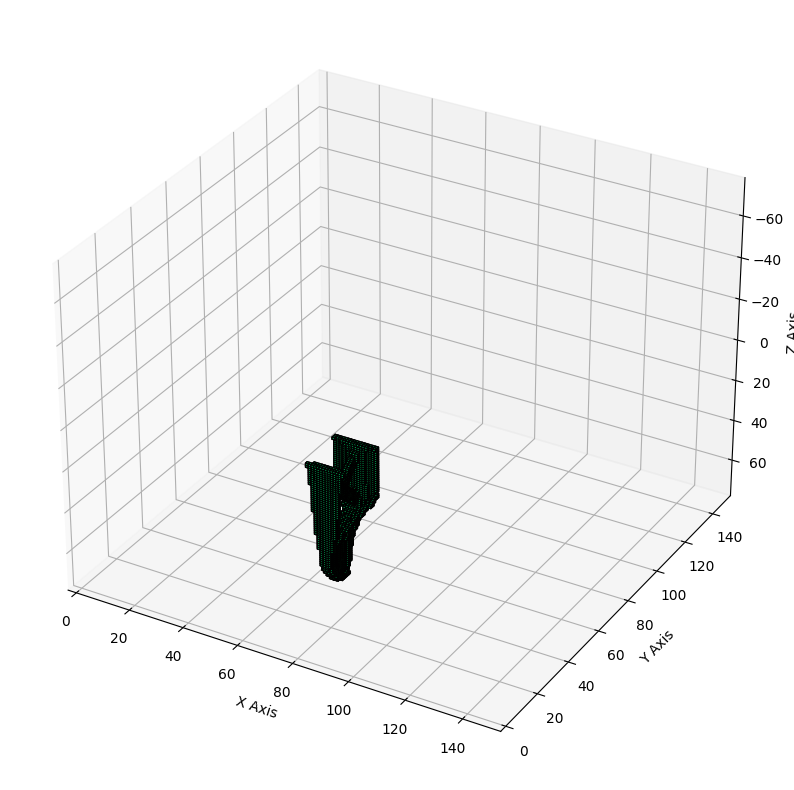

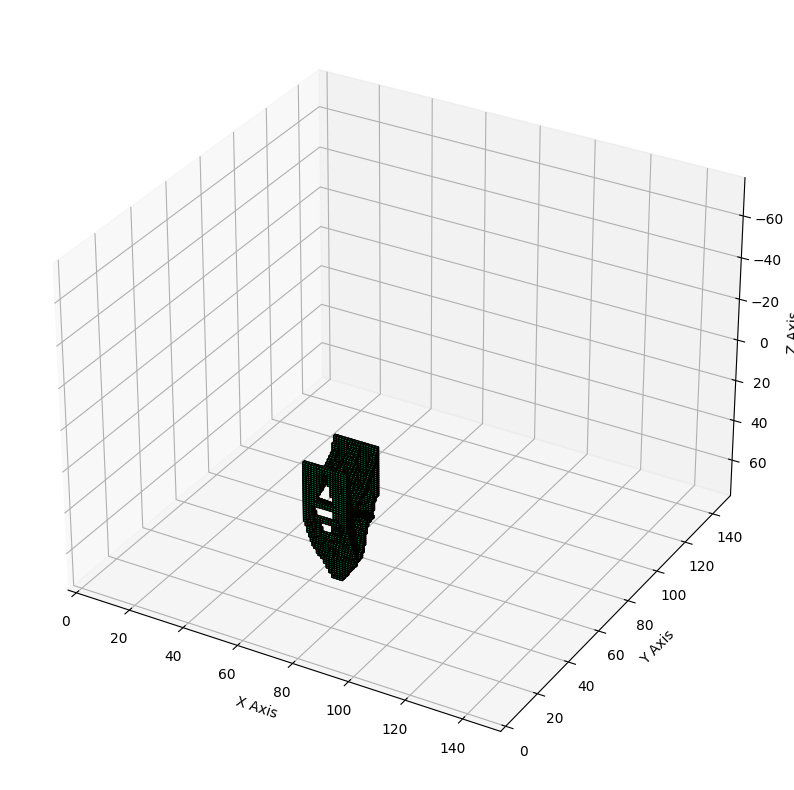

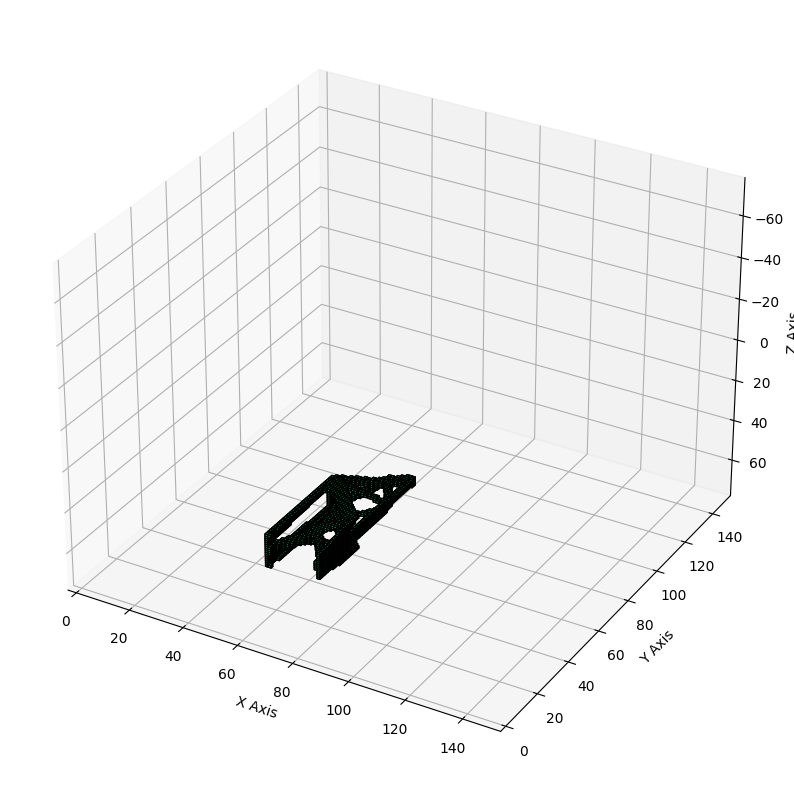

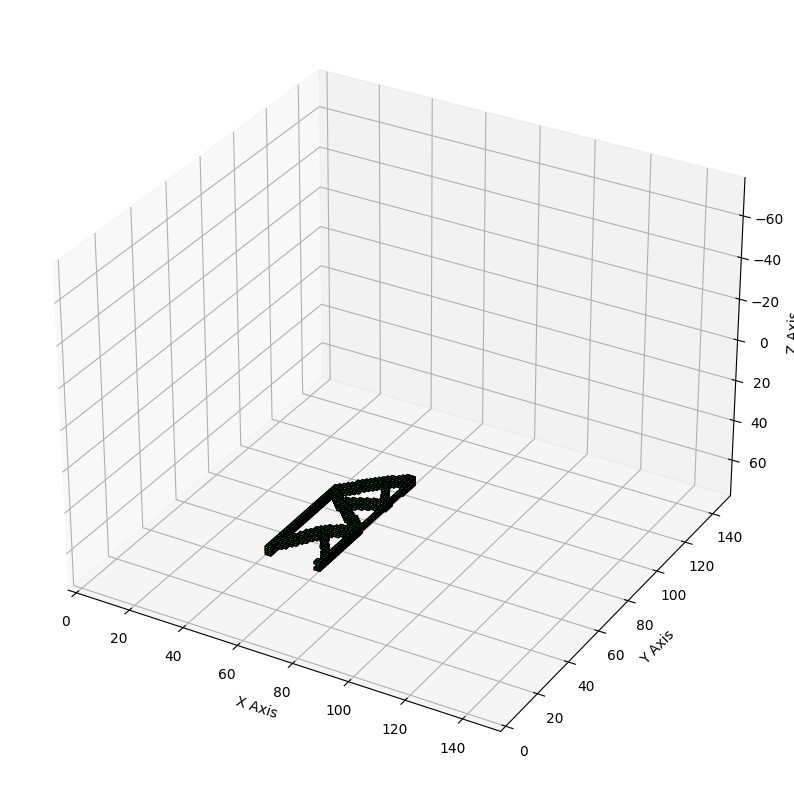

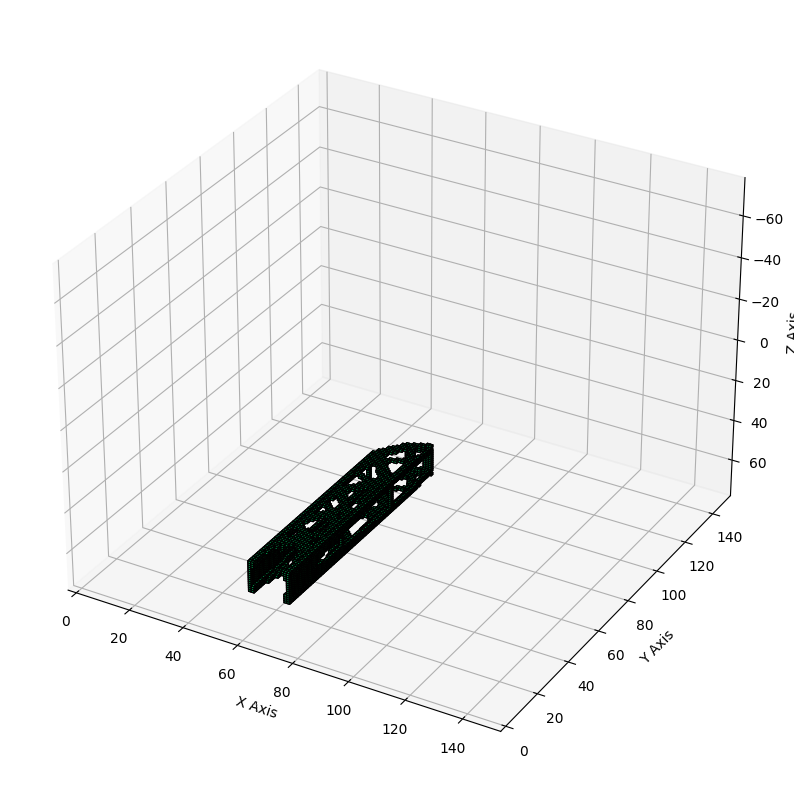

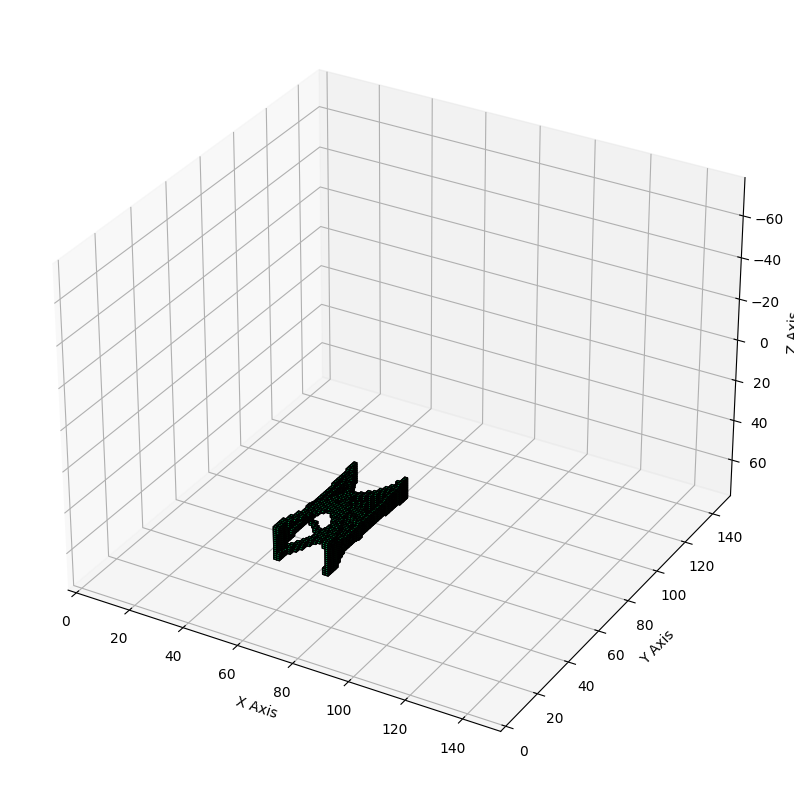

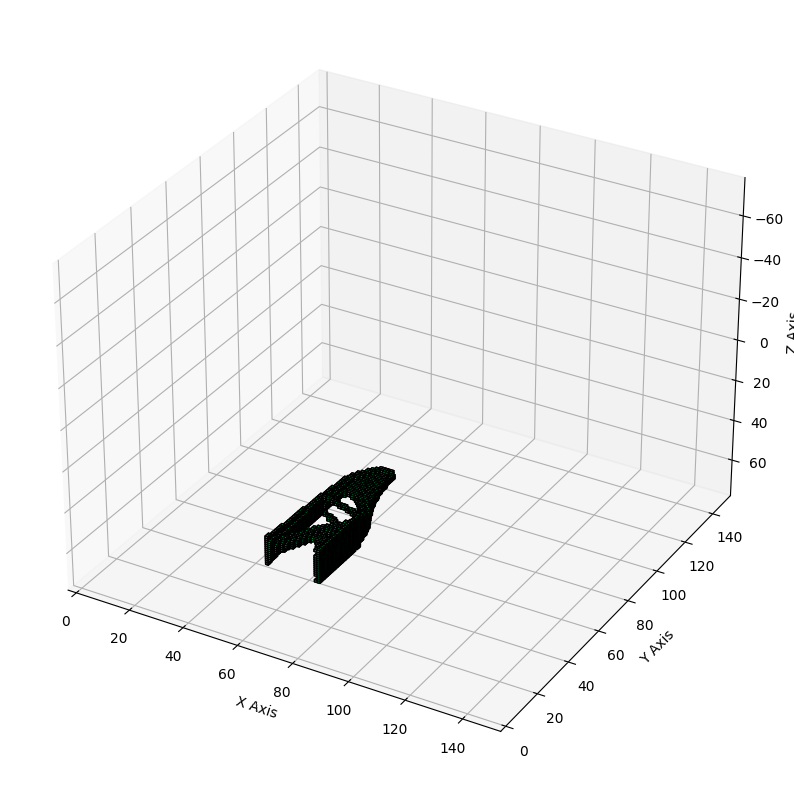

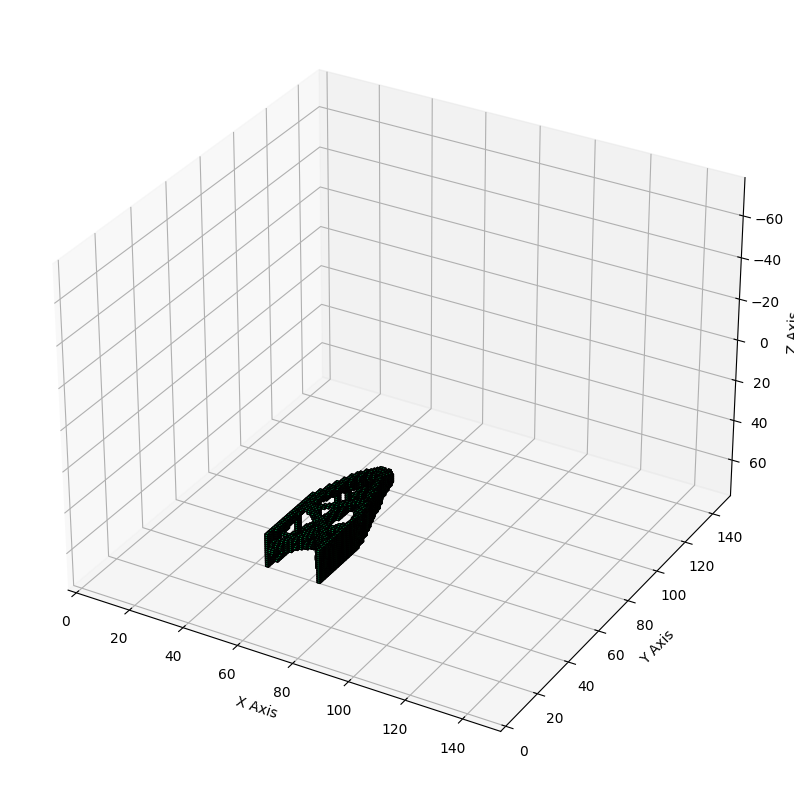

In [6]:
import numpy as np
import glob
import matplotlib.pyplot as plt

labeldata_index = glob.glob('../../Matlab_files/data/npdata/input/*.npy')
labeldata_index = glob.glob('../../Matlab_files/data/npdata/label/*.npy')
for i in range(len(labeldata_index)):
    print('第',i,'组输入数据')
    labeldata = np.load(labeldata_index[i])
    labeldata = labeldata.transpose(1, 2, 0)
    mycolormap = plt.get_cmap('winter')
    labeldata_max = labeldata.max()
    relativevalue = np.round(labeldata / labeldata_max, 1)
    colorsvalues = mycolormap(relativevalue)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 150)
    ax.set_zlim(75, -75)
    ax.voxels(labeldata, facecolors=colorsvalues,edgecolors = 'k', shade = False)

for i in range(len(labeldata_index)):
    print('第',i,'组标签数据')
    labeldata = np.load(labeldata_index[i])
    labeldata = labeldata.transpose(2, 0, 1)
    mycolormap = plt.get_cmap('winter')
    labeldata_max = labeldata.max()
    relativevalue = np.round(labeldata / labeldata_max, 1)
    colorsvalues = mycolormap(relativevalue)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 150)
    ax.set_zlim(75, -75)
    ax.voxels(labeldata, facecolors=colorsvalues,edgecolors = 'k', shade = False)


In [3]:
import numpy as np

data = np.load('../../Matlab_files/dataset/Dataset/input/0.npy')
print(data.shape)

(1, 120, 120, 120)
